# More Computer Vision applications

## This notebook demonstrates ability training a CNN model on CIFAR dataset

1. We apply a CNN architecture in a more streamlined fashion to perform multiclass classification on a more challenging dataset with color images - CIFAR100 - from `torchvision.datasets`.

2. We convert dataset into DataLoader.

3. We build and train a Convolutional Neural Network (CNN) model.

4. We evaluate performance of model using loss, accuracy and confusion matrices. 

5. We make predictions on test set with best performing (CNN) model.

6. Finally, we begin to think about transfer learning using models provided in `torchvision.models`.

<hr style="border:1px solid black">

# 0. Preliminaries

In [1]:
# Imports

import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import models

# Import DataLoader
from torch.utils.data import DataLoader

# Import torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix

# Import plotting modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path

# Import timer to see how fast code runs.
from timeit import default_timer as timer
from tqdm.auto import tqdm         # for progress bar

import mlxtend # to plot confusion matrix
from mlxtend.plotting import plot_confusion_matrix

import helper_functions as hf
import models as m

# Check versions
print(f"PyTorch Version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

PyTorch Version: 1.12.0
torchvision version: 0.13.0
mlxtend version: 0.22.0


In [2]:
# Device Agnostic Code

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Hyperparameters

EPOCHS = 7
LEARNING_RATE = 0.1
HIDDEN_UNITS = 20

<hr style="border:1px solid black">

# 1. Get Dataset and Visualize it.

In [4]:
train_data = datasets.CIFAR100(root = 'data',
                               train = True,
                               download = True,
                               transform = ToTensor(),
                               target_transform = None)

test_data = datasets.CIFAR100(root = 'data',
                              train = False,
                              download = True,
                              transform = ToTensor(),
                              target_transform = None)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f"Train Data shape: {len(train_data)}")
print(f"Test Data shape: {len(test_data)}")

Train Data shape: 50000
Test Data shape: 10000


In [6]:
# Load in first image and label to get feel for shapes and sizes

class_names = train_data.classes

img, lbl = train_data[0]

color_chans = img.shape[0] 
img_dim1 = img.shape[1] 
img_dim2 = img.shape[2] 

print(f"Image shape: {img.shape}")
print(f" Label: {lbl}, {class_names[lbl]}")

Image shape: torch.Size([3, 32, 32])
 Label: 19, cattle


In [7]:
color_chans

3

In [8]:
# Visualize first training data point.
if False:
    img, lbl = train_data[0]
    print(f"Image shape: {img.shape} | Label: {lbl}") 
    hf.imshow_img(img)
    plt.title(class_names[lbl])
    plt.axis(False)
    plt.show()

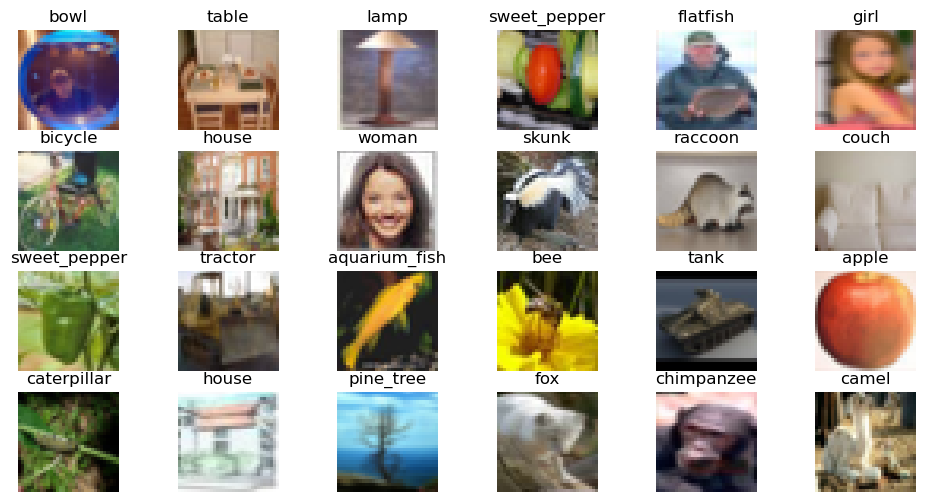

In [9]:
# Plot some random images from the training dataset
torch.manual_seed(316)
plt.figure(figsize=(12,6))
rows, cols = 4, 6
for i in range(1, rows*cols+1):
    indx = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[indx]
    plt.subplot(rows, cols, i)
    hf.imshow_img(img)
    plt.title(class_names[lbl])
    plt.axis(False)

<hr style="border:1px solid black">

# 2. Prepare DataLoader

In [10]:
# Make DataLoader for train and test datasets.

BATCHSIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCHSIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCHSIZE,
                             shuffle = False)

print(f"Training Dataset has {len(train_dataloader)} batches of size {BATCHSIZE}")
print(f"Test Dataset has {len(test_dataloader)} batches of size {BATCHSIZE}")

Training Dataset has 1563 batches of size 32
Test Dataset has 313 batches of size 32


<hr style="border:1px solid black">

# 3. Train TinyVGG Model

In [11]:
# Instantiate model - it is defined in models.py

model0 = m.TinyVGG_CIFAR(input_shape=color_chans,
                   hidden_units=HIDDEN_UNITS,
                   output_shape=len(class_names))

model0

TinyVGG_CIFAR(
  (conv_block1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1280, out_features=100, bias=True)
  )
)

In [12]:
# Define Loss function, Optimizer & Accuracy
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=LEARNING_RATE)

accuracy_fn = Accuracy(task='multiclass',num_classes=len(class_names))

In [13]:
# Loop through data and do training and test steps.

epoch_count = []
train_loss_count = []
train_acc_count = []
test_loss_count = []
test_acc_count = []


time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    
    print(f"\n Epoch: {epoch} \n --------")
    
    train_loss, train_acc = m.train_step_batch_multi_classification(model=model0,
                                                                    dataloader=train_dataloader,
                                                                    optimizer=optimizer,
                                                                    loss_fn=loss_fn,
                                                                    accuracy_fn=accuracy_fn,
                                                                    device=device,
                                                                    verbose_model=False)
    
    test_loss, test_acc = m.test_step_batch_multi_classification(model=model0,
                                                                 dataloader=test_dataloader,
                                                                 loss_fn=loss_fn,
                                                                 accuracy_fn=accuracy_fn,
                                                                 device=device)

    # Gather up metrics to plot after training
    epoch_count.append(epoch)
    train_loss_count.append(train_loss.item())
    train_acc_count.append(train_acc.item())
    test_loss_count.append(test_loss.item())
    test_acc_count.append(test_acc.item())

    
time_end = timer()

print("")
model0_train_time = hf.print_train_time(time_start, time_end, device)

print("")
model0_results = m.eval_model_multi_classification(model=model0,
                                                   dataloader=test_dataloader,
                                                   loss_fn=loss_fn,
                                                   accuracy_fn=accuracy_fn,
                                                   device=device)
print(f"\n model0 results: \n {model0_results}")

  0%|          | 0/7 [00:00<?, ?it/s]


 Epoch: 0 
 --------
Train loss: 4.38363 | Train accuracy: 0.0452
Test loss: 3.96318 | Test accuracy: 0.1066

 Epoch: 1 
 --------
Train loss: 3.53963 | Train accuracy: 0.1802
Test loss: 3.26068 | Test accuracy: 0.2340

 Epoch: 2 
 --------
Train loss: 3.03546 | Train accuracy: 0.2724
Test loss: 3.10771 | Test accuracy: 0.2694

 Epoch: 3 
 --------
Train loss: 2.76095 | Train accuracy: 0.3234
Test loss: 3.18947 | Test accuracy: 0.2391

 Epoch: 4 
 --------
Train loss: 2.56665 | Train accuracy: 0.3586
Test loss: 3.14329 | Test accuracy: 0.2748

 Epoch: 5 
 --------
Train loss: 2.42730 | Train accuracy: 0.3900
Test loss: 3.14215 | Test accuracy: 0.2706

 Epoch: 6 
 --------
Train loss: 2.31122 | Train accuracy: 0.4140
Test loss: 3.03913 | Test accuracy: 0.2888

Train time on cpu: 454.146 seconds.

Eval model TinyVGG_CIFAR on dataset Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


  0%|          | 0/313 [00:00<?, ?it/s]


 model0 results: 
 {'model_name': 'TinyVGG_CIFAR', 'model_loss': 3.039130926132202, 'model_acc': 0.28883785009384155}


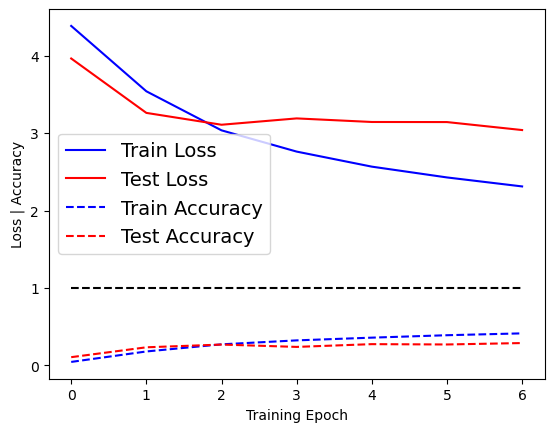

In [14]:
# Plot loss and accuracy during training

hf.plot_loss(epoch=epoch_count, 
             loss=train_loss_count, 
             test_loss=test_loss_count, 
             acc=train_acc_count, 
             test_acc=test_acc_count, 
             y_scale='linear')

<hr style="border:1px solid black">

# 4. Visualize model performance and results

60 torch.Size([3, 32, 32])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


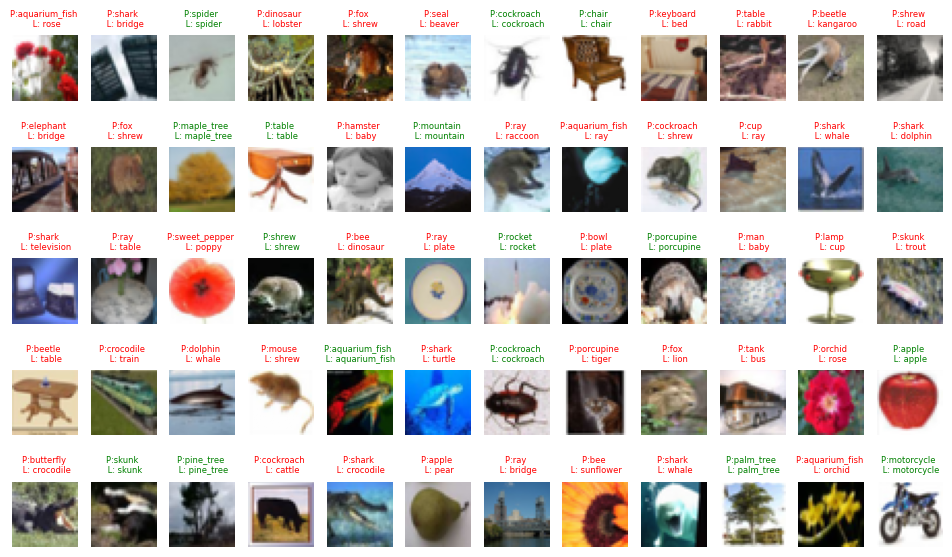

In [15]:
# Take a few random samples from test_data: make predictions and plot results.
rows=5
cols=12
num_samples=rows*cols

#random.seed(316)

image_samples = []
label_samples = []

for img,lbl in random.sample(list(test_data),k=num_samples):
    image_samples.append(img)
    label_samples.append(lbl)
    
print(len(image_samples),image_samples[0].shape)

# Make predictions from image_samples
pred_probs = m.make_predictions_multi_classification(model=model0,
                                                     data=image_samples)


# Plot predictions in a grid
plt.figure(figsize=(12,7))

for i, img in enumerate(image_samples):

    plt.subplot(rows, cols, i+1)
    hf.imshow_img(img)

    y_infer = model0(img.unsqueeze(0))
    if y_infer.argmax().item()==label_samples[i]:
        title_color = 'green' # if model prediction was correct
    else:
        title_color = 'red' # if model prediction was incorrect
    plt.title(f"P:{class_names[y_infer.argmax().item()]} \n L: {class_names[label_samples[i]]}",
              color=title_color,
              fontsize=6)
    plt.axis(False);


In [16]:
# Make predictions across whole test_data set.

y_preds = []

model0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        
        # 1. Send data to device
        X, y = X.to(device), y.to(device)
        
        # 2. Forward pass
        y_logit = model0(X)
        
        # 3. Convert logit -> probability -> prediction.
        y_prob = y_logit.softmax(dim=1)
        y_pred = y_prob.argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        
    y_preds_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
# Plot confusion matrix using mlxtend and torchmetrics

confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor, 
                         target=torch.tensor(test_data.targets)
                        )

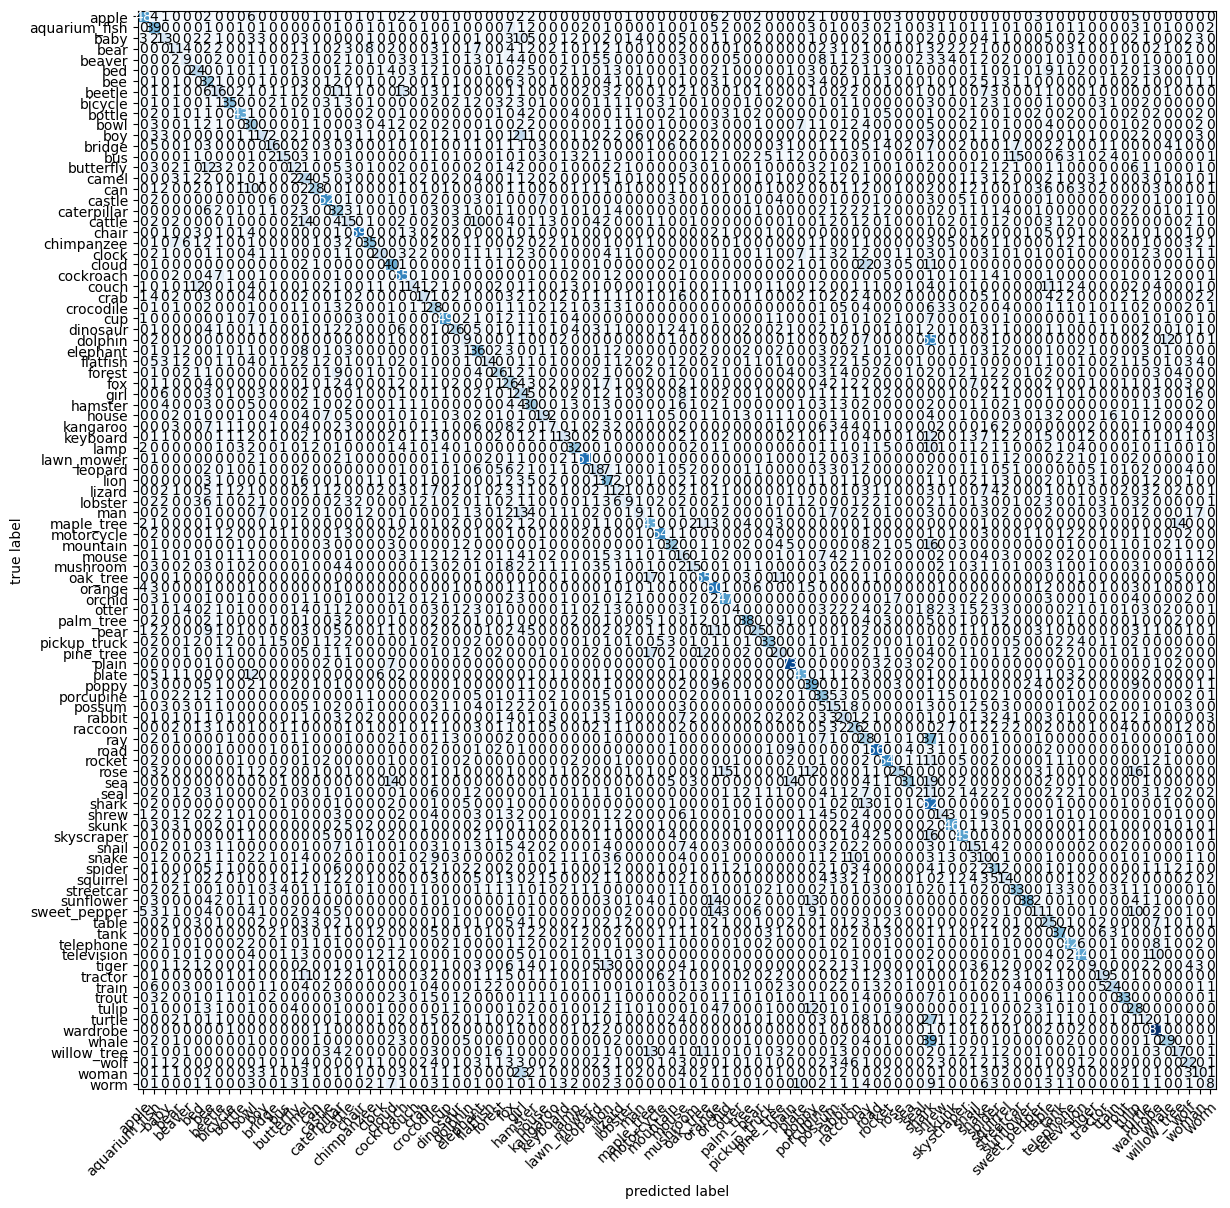

In [18]:
fig,ax = plot_confusion_matrix(
                                conf_mat = confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(18,14)
                               )

<hr style="border:1px solid black">

# 5. Some torchvision builtin models

In [19]:
vgg16 = torchvision.models.vgg16(pretrained=True)

/Users/chriswarner/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/chriswarner/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
num_params = m.count_up_params(vgg16)

Number of parameters in model: 138357544


In [22]:
y_logit = vgg16(img.unsqueeze(0))

In [23]:
y_logit.shape

torch.Size([1, 1000])

Oh, this model was trained on imagenet. Doesnt make sense to apply it to CIFAR100. But ImageNet dataset not available in torchvision anymore and it is massive.

In [24]:
# train_data_imagenet = datasets.ImageNet(root='data',
#                                         split='train',
#                                         download = True)


# test_data_imagenet = 

# train_data = datasets.CIFAR100(root = 'data',
#                                train = True,
#                                download = True,
#                                transform = ToTensor(),
#                                target_transform = None)

**Takeaway:** We will explore more Transfer Learning with models trained on ImageNet and using subsets of the ImageNet dataset in notebooks 06 and 06b